## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [3]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

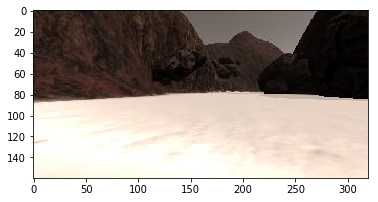

In [4]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

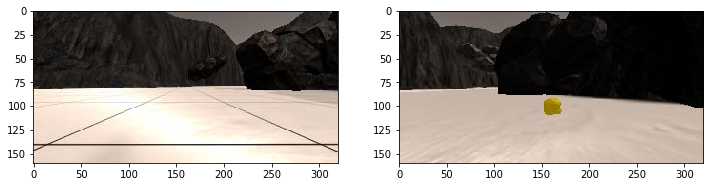

In [5]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

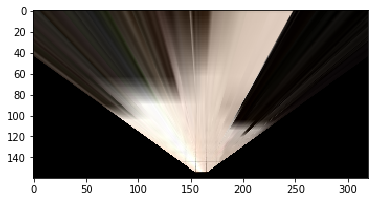

In [6]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

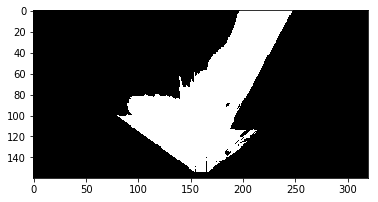

In [7]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

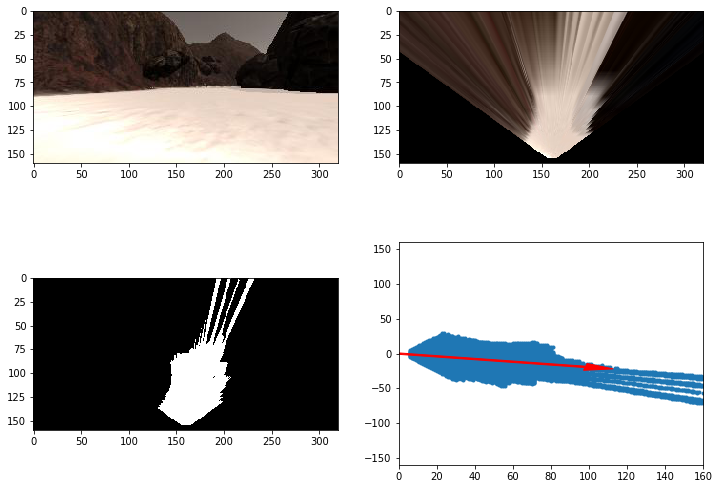

In [8]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [9]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [32]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    print("current x",data.xpos[data.count], "current y",data.ypos[data.count],"current yaw", data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
#     source = np.float32([[119, 96], 
#                  [200,96], 
#                  [304,139], 
#                  [16,139]]) #My measured values from Perception exercise.
#     destination = np.float32([[image.shape[1]//2-10, image.shape[0]-10], 
#                  [image.shape[1]//2, image.shape[0]-10], 
#                  [image.shape[1]//2, image.shape[0]], 
#                  [image.shape[1]//2-10, image.shape[0]]]) #10px*10px Bottom center
###From test notebook:
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    # The destination box will be 2*dst_size on each side
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    # this is just a rough guess, feel free to change it!
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    transformed_image = perspect_transform(image, source, destination)
    transformed_image_background_ind = np.argwhere(transformed_image[:,:,0]==0)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #Find terrain:
    navigable = color_thresh(transformed_image, rgb_thresh=(160, 160, 160)) #Better fidelity with 170 instead of 160. 150 makes it worse.
    #Invert to find obstacles and substract background from perspective transform:
    obstacle = np.invert(navigable)
    obstacle = obstacle - np.min(obstacle) #normalize after inverting
    obstacle[transformed_image_background_ind[:,0],transformed_image_background_ind[:,1]] = 0
#     plt.imshow(obstacle,cmap='gray')
#     plt.show()
    #Find rock samples by thresholding to find yellow (RGB)(255,255,0)
    rock_thresh=(150, 140, 80) #Using a color picker tool, found the RBG color of some rocks (150, 140, 80), which fall within these bounds.
    rock = np.zeros_like(image[:,:,0])
    above_thresh = (image[:,:,0] > rock_thresh[0]) \
                & (image[:,:,1] > rock_thresh[1]) \
                & (image[:,:,2] < rock_thresh[2]) #Referenced from function above but changed it up for the  in Blue channel
    rock[above_thresh] = 1
    # 4) Convert thresholded image pixel values to rover-centric coords
    navigable_x_rover, navigable_y_rover =  rover_coords(navigable)
    obstacle_x_rover, obstacle_y_rover =  rover_coords(obstacle)
    rock_x_rover, rock_y_rover =  rover_coords(rock)
    # 5) Convert rover-centric pixel values to world coords
    navigable_x_world,navigable_y_world =  pix_to_world(navigable_x_rover, navigable_y_rover, data.xpos[data.count],data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)
    obstacle_x_world ,obstacle_y_world=  pix_to_world(obstacle_x_rover, obstacle_y_rover, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0],  10)
    rock_x_world,rock_y_world =  pix_to_world(rock_x_rover, rock_y_rover, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 10
    data.worldmap[rock_y_world, rock_x_world, 1] += 10
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 255
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Rover position: x="+str(data.xpos[data.count])+", y="+str(data.ypos[data.count]), (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

current x 99.66999 current y 85.58896999999999 current yaw 56.82555
[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


  0%|                                                  | 0/283 [00:00<?, ?it/s]

current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.66999 current y 85.58896999999999 current yaw 56.82555


  2%|▋                                         | 5/283 [00:00<00:06, 45.02it/s]

current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.66999 current y 85.58896999999999 current yaw 56.82555
current x 99.67065 current y 85.58999 current yaw 56.82556999999999
current x 99.67067 current y 85.59003 current yaw 56.825419999999994


  4%|█▍                                       | 10/283 [00:00<00:05, 46.14it/s]

current x 99.67067 current y 85.59003 current yaw 56.825419999999994
current x 99.67066 current y 85.59003 current yaw 56.825419999999994
current x 99.67066 current y 85.59003 current yaw 56.825419999999994
current x 99.67065 current y 85.59003 current yaw 56.825419999999994
current x 99.67065 current y 85.59003 current yaw 56.82541


  5%|██▏                                      | 15/283 [00:00<00:05, 47.22it/s]

current x 99.67064 current y 85.59003 current yaw 56.82541
current x 99.67064 current y 85.59003 current yaw 56.82541
current x 99.67063 current y 85.59003 current yaw 56.82541
current x 99.67062 current y 85.59003 current yaw 56.82541
current x 99.67062 current y 85.59003 current yaw 56.82541


  7%|██▉                                      | 20/283 [00:00<00:05, 47.60it/s]

current x 99.67062 current y 85.59004 current yaw 56.8254
current x 99.67062 current y 85.59005 current yaw 56.8254
current x 99.67062 current y 85.59005 current yaw 56.8254
current x 99.6708 current y 85.59031999999999 current yaw 56.82637
current x 99.67083000000001 current y 85.59038000000001 current yaw 56.81548000000001


  9%|███▌                                     | 25/283 [00:00<00:05, 47.33it/s]

current x 99.67175999999999 current y 85.5918 current yaw 56.8225
current x 99.67331999999999 current y 85.59421 current yaw 56.715019999999996
current x 99.67529 current y 85.59719 current yaw 56.69259
current x 99.67777 current y 85.60096 current yaw 56.73291
current x 99.68341 current y 85.6096 current yaw 56.871809999999996


 11%|████▎                                    | 30/283 [00:00<00:05, 47.81it/s]

current x 99.68764 current y 85.61605 current yaw 56.75683000000001
current x 99.69625 current y 85.62921999999999 current yaw 56.750859999999996
current x 99.70283 current y 85.63936 current yaw 56.889109999999995
current x 99.71024 current y 85.65078000000001 current yaw 56.9262
current x 99.71786999999999 current y 85.66252 current yaw 56.97526


 12%|█████                                    | 35/283 [00:00<00:05, 48.30it/s]

current x 99.72574 current y 85.67455 current yaw 57.014480000000006
current x 99.73706999999999 current y 85.69167 current yaw 56.986019999999996
current x 99.74576 current y 85.70506 current yaw 56.935390000000005
current x 99.76088 current y 85.72845 current yaw 56.8792
current x 99.77776 current y 85.75455 current yaw 56.884809999999995


 14%|█████▊                                   | 40/283 [00:00<00:05, 47.53it/s]

current x 99.79700000000001 current y 85.78428000000001 current yaw 56.86581999999999
current x 99.81023 current y 85.8047 current yaw 56.835519999999995
current x 99.83139 current y 85.83752 current yaw 56.96938000000001
current x 99.84605 current y 85.86028 current yaw 57.063869999999994
current x 99.86151 current y 85.88438000000001 current yaw 57.10579


 16%|██████▌                                  | 45/283 [00:00<00:04, 47.69it/s]

current x 99.87763000000001 current y 85.90944 current yaw 57.08944
current x 99.90364 current y 85.94996 current yaw 57.10592
current x 99.92182 current y 85.9783 current yaw 57.13094
current x 99.95082 current y 86.02351 current yaw 57.156780000000005
current x 99.97074 current y 86.05458 current yaw 57.21354


 18%|███████▏                                 | 50/283 [00:01<00:04, 46.98it/s]

current x 99.99143000000001 current y 86.08694 current yaw 57.22939
current x 100.0236 current y 86.13731 current yaw 57.23721
current x 100.0459 current y 86.17214 current yaw 57.2653
current x 100.0807 current y 86.22678 current yaw 57.22249
current x 100.1048 current y 86.26463000000001 current yaw 57.227819999999994


 19%|███████▉                                 | 55/283 [00:01<00:04, 47.03it/s]

current x 100.1422 current y 86.32311999999999 current yaw 57.256009999999996
current x 100.1679 current y 86.36343000000001 current yaw 57.274930000000005
current x 100.2078 current y 86.42599 current yaw 57.31474
current x 100.2352 current y 86.469 current yaw 57.33373
current x 100.2775 current y 86.53555 current yaw 57.359790000000004


 21%|████████▋                                | 60/283 [00:01<00:04, 47.33it/s]

current x 100.3065 current y 86.58121 current yaw 57.36985
current x 100.3362 current y 86.62803000000001 current yaw 57.3862
current x 100.382 current y 86.7002 current yaw 57.402919999999995
current x 100.4134 current y 86.7497 current yaw 57.41326
current x 100.4454 current y 86.80023 current yaw 57.42235


 23%|█████████▍                               | 65/283 [00:01<00:04, 47.27it/s]

current x 100.4947 current y 86.87801 current yaw 57.43326999999999
current x 100.5284 current y 86.93118 current yaw 57.441309999999994
current x 100.5801 current y 87.0129 current yaw 57.45065
current x 100.6154 current y 87.06869 current yaw 57.4585
current x 100.6696 current y 87.15439 current yaw 57.46998000000001


 25%|██████████▏                              | 70/283 [00:01<00:04, 47.50it/s]

current x 100.7065 current y 87.21281 current yaw 57.47704
current x 100.7441 current y 87.27225 current yaw 57.484230000000004
current x 100.8016 current y 87.36334000000001 current yaw 57.496230000000004
current x 100.8408 current y 87.42538 current yaw 57.5027
current x 100.9008 current y 87.52039 current yaw 57.5137


 27%|██████████▊                              | 75/283 [00:01<00:04, 47.66it/s]

current x 100.9416 current y 87.58498 current yaw 57.520869999999995
current x 100.98299999999999 current y 87.65063 current yaw 57.52985
current x 101.0463 current y 87.75102 current yaw 57.540659999999995
current x 101.0892 current y 87.81926 current yaw 57.5657
current x 101.1536 current y 87.92416 current yaw 57.835409999999996


 28%|███████████▌                             | 80/283 [00:01<00:04, 47.50it/s]

current x 101.1962 current y 87.99583 current yaw 58.207919999999994
current x 101.2594 current y 88.10625999999999 current yaw 59.00399
current x 101.3006 current y 88.18200999999999 current yaw 59.70157
current x 101.3412 current y 88.25932 current yaw 60.47002
current x 101.4032 current y 88.37705 current yaw 61.36253000000001


 30%|████████████▎                            | 85/283 [00:01<00:04, 47.39it/s]

current x 101.4455 current y 88.45683000000001 current yaw 61.73438
current x 101.4889 current y 88.53773000000001 current yaw 61.90596
current x 101.5549 current y 88.66154 current yaw 61.974869999999996
current x 101.5995 current y 88.74553 current yaw 61.989180000000005
current x 101.6669 current y 88.87303 current yaw 62.00551


 32%|█████████████                            | 90/283 [00:01<00:04, 47.59it/s]

current x 101.7122 current y 88.95907 current yaw 62.01611
current x 101.7581 current y 89.0461 current yaw 62.02626
current x 101.8279 current y 89.17898000000001 current yaw 62.0603
current x 101.8742 current y 89.26921 current yaw 62.24748
current x 101.92 current y 89.36086 current yaw 62.61549
current x 101.9889 current y 89.50081 current yaw 63.19849


 34%|█████████████▉                           | 96/283 [00:02<00:03, 48.04it/s]

current x 102.0354 current y 89.59543000000001 current yaw 63.45715
current x 102.1059 current y 89.7394 current yaw 63.721019999999996
current x 102.1525 current y 89.83711 current yaw 64.00562
current x 102.1983 current y 89.93626 current yaw 64.45742
current x 102.2668 current y 90.0874 current yaw 65.16776


 36%|██████████████▎                         | 101/283 [00:02<00:03, 46.96it/s]

current x 102.3126 current y 90.1897 current yaw 65.52991
current x 102.3819 current y 90.34528 current yaw 65.91586
current x 102.4286 current y 90.45034 current yaw 66.03239
current x 102.4752 current y 90.55662 current yaw 66.20061
current x 102.5432 current y 90.71885 current yaw 66.8178


 37%|██████████████▉                         | 106/283 [00:02<00:03, 47.15it/s]

current x 102.5876 current y 90.82874 current yaw 67.36688000000001
current x 102.6548 current y 90.99569 current yaw 67.95786
current x 102.6999 current y 91.10857 current yaw 68.22184
current x 102.766 current y 91.28044 current yaw 68.80521999999999
current x 102.8079 current y 91.39690999999999 current yaw 69.4617


 39%|███████████████▋                        | 111/283 [00:02<00:03, 47.01it/s]

current x 102.8484 current y 91.51441 current yaw 70.25198
current x 102.90700000000001 current y 91.69287 current yaw 71.47055
current x 102.9441 current y 91.81376999999999 current yaw 72.28815999999999
current x 102.9981 current y 91.99757 current yaw 73.38407
current x 103.0315 current y 92.12179 current yaw 74.25146


 41%|████████████████▍                       | 116/283 [00:02<00:03, 46.27it/s]

current x 103.0779 current y 92.3102 current yaw 75.75044
current x 103.1073 current y 92.43719 current yaw 76.63359
current x 103.1502 current y 92.63037 current yaw 77.56241
current x 103.1788 current y 92.76096 current yaw 77.88167
current x 103.2078 current y 92.89313 current yaw 78.01364000000001


 43%|█████████████████                       | 121/283 [00:02<00:03, 46.52it/s]

current x 103.2514 current y 93.09423000000001 current yaw 78.07328000000001
current x 103.2809 current y 93.23 current yaw 78.0602
current x 103.3109 current y 93.3671 current yaw 78.00909
current x 103.3565 current y 93.57526 current yaw 77.91139
current x 103.3872 current y 93.71566999999999 current yaw 77.87611


 45%|█████████████████▊                      | 126/283 [00:02<00:03, 46.32it/s]

current x 103.4181 current y 93.85728 current yaw 77.85344
current x 103.465 current y 94.07202 current yaw 77.82884
current x 103.4968 current y 94.21663000000001 current yaw 77.79743
current x 103.5464 current y 94.43549 current yaw 77.56206999999999
current x 103.5813 current y 94.58248 current yaw 77.24284


 46%|██████████████████▌                     | 131/283 [00:02<00:03, 46.30it/s]

current x 103.6179 current y 94.7302 current yaw 76.78392
current x 103.6753 current y 94.95196 current yaw 75.7267
current x 103.7159 current y 95.09849 current yaw 74.72603000000001
current x 103.7826 current y 95.31466 current yaw 72.68961
current x 103.8311 current y 95.45625 current yaw 71.1333


 48%|███████████████████▏                    | 136/283 [00:02<00:03, 46.29it/s]

current x 103.8835 current y 95.59643 current yaw 69.47205
current x 103.9723 current y 95.80537 current yaw 67.06825
current x 104.0359 current y 95.94311 current yaw 65.52441999999999
current x 104.1021 current y 96.0809 current yaw 64.05154
current x 104.2066 current y 96.28983000000001 current yaw 62.065940000000005


 50%|███████████████████▉                    | 141/283 [00:02<00:03, 46.15it/s]

current x 104.2803 current y 96.42988000000001 current yaw 60.780080000000005
current x 104.4 current y 96.63942 current yaw 58.65003000000001
current x 104.4846 current y 96.7762 current yaw 57.1133
current x 104.574 current y 96.90939 current yaw 55.41125
current x 104.71799999999999 current y 97.10325999999999 current yaw 52.96165


 52%|████████████████████▋                   | 146/283 [00:03<00:02, 46.45it/s]

current x 104.8186 current y 97.23083000000001 current yaw 51.45167
current x 104.9224 current y 97.35765 current yaw 50.0022
current x 105.0851 current y 97.54298 current yaw 47.7893
current x 105.1978 current y 97.6636 current yaw 46.28237
current x 105.3751 current y 97.83971 current yaw 44.04572


 53%|█████████████████████▎                  | 151/283 [00:03<00:02, 46.91it/s]

current x 105.4971 current y 97.95413 current yaw 42.55407
current x 105.6225 current y 98.06591 current yaw 41.06266
current x 105.7513 current y 98.17452 current yaw 39.58194
current x 105.9511 current y 98.33268000000001 current yaw 37.37595
current x 106.0881 current y 98.43437 current yaw 35.897040000000004


 55%|██████████████████████                  | 156/283 [00:03<00:02, 46.59it/s]

current x 106.2282 current y 98.53296999999999 current yaw 34.41616
current x 106.4444 current y 98.67451 current yaw 32.218790000000006
current x 106.59200000000001 current y 98.76510999999999 current yaw 30.74901
current x 106.7424 current y 98.85236 current yaw 29.266609999999996
current x 106.9736 current y 98.9761 current yaw 27.0724


 57%|██████████████████████▊                 | 161/283 [00:03<00:02, 46.23it/s]

current x 107.1309 current y 99.05443000000001 current yaw 25.60793
current x 107.2907 current y 99.12914 current yaw 24.13171
current x 107.45299999999999 current y 99.19995 current yaw 22.658070000000002
current x 107.7011 current y 99.29843000000001 current yaw 20.4811
current x 107.8691 current y 99.35991999999999 current yaw 19.043879999999998


 59%|███████████████████████▍                | 166/283 [00:03<00:02, 43.92it/s]

current x 108.039 current y 99.41705 current yaw 17.58406
current x 108.2115 current y 99.47005 current yaw 16.13737
current x 108.4734 current y 99.54164 current yaw 13.96394
current x 108.6505 current y 99.58436999999999 current yaw 12.543460000000001
current x 108.8291 current y 99.62321999999999 current yaw 11.10295


 60%|████████████████████████▏               | 171/283 [00:03<00:02, 44.96it/s]

current x 109.1 current y 99.67268 current yaw 8.941550999999999
current x 109.2824 current y 99.70014 current yaw 7.503280999999999
current x 109.4658 current y 99.72329 current yaw 6.06736
current x 109.6512 current y 99.7411 current yaw 4.633476
current x 109.8367 current y 99.7557 current yaw 3.278915


 62%|████████████████████████▉               | 176/283 [00:03<00:02, 44.74it/s]

current x 110.1172 current y 99.77056 current yaw 1.210754
current x 110.305 current y 99.773 current yaw 359.7514
current x 110.4939 current y 99.77105999999999 current yaw 358.3399
current x 110.7779 current y 99.76071999999999 current yaw 356.2529
current x 110.9682 current y 99.7477 current yaw 354.8669


 64%|█████████████████████████▌              | 181/283 [00:03<00:02, 44.70it/s]

current x 111.1586 current y 99.73002 current yaw 353.4712
current x 111.4444 current y 99.69476 current yaw 351.37699999999995
current x 111.6347 current y 99.66462 current yaw 349.9948
current x 111.9206 current y 99.61458 current yaw 348.0704
current x 112.1109 current y 99.57439000000001 current yaw 346.7065


 66%|██████████████████████████▎             | 186/283 [00:03<00:02, 45.16it/s]

current x 112.3008 current y 99.52911999999999 current yaw 345.4606
current x 112.5858 current y 99.45514 current yaw 343.9397
current x 112.77600000000001 current y 99.40215 current yaw 343.1592
current x 112.9664 current y 99.34651 current yaw 342.5939
current x 113.1575 current y 99.28871 current yaw 342.2404


 67%|██████████████████████████▉             | 191/283 [00:04<00:02, 45.61it/s]

current x 113.4448 current y 99.19936 current yaw 341.9935
current x 113.6363 current y 99.13851 current yaw 341.921
current x 113.82799999999999 current y 99.07708000000001 current yaw 341.8993
current x 114.02 current y 99.01573 current yaw 341.9667
current x 114.3093 current y 98.92374000000001 current yaw 342.1723


 69%|███████████████████████████▋            | 196/283 [00:04<00:01, 46.44it/s]

current x 114.5023 current y 98.86247 current yaw 342.2795
current x 114.7918 current y 98.77076 current yaw 342.3696
current x 114.9853 current y 98.70954 current yaw 342.4014
current x 115.179 current y 98.64849 current yaw 342.4269
current x 115.3727 current y 98.58759 current yaw 342.4516


 71%|████████████████████████████▍           | 201/283 [00:04<00:01, 45.13it/s]

current x 115.5666 current y 98.52696999999999 current yaw 342.4971
current x 115.7608 current y 98.46669 current yaw 342.5748
current x 116.0503 current y 98.37451999999999 current yaw 342.6274
current x 116.3369 current y 98.28401 current yaw 342.8096
current x 116.5242 current y 98.22676 current yaw 343.0958


 73%|█████████████████████████████           | 206/283 [00:04<00:01, 44.85it/s]

current x 116.8111 current y 98.14166999999999 current yaw 343.61199999999997
current x 117.0034 current y 98.08728 current yaw 344.1548
current x 117.2933 current y 98.01138 current yaw 345.3754
current x 117.4871 current y 97.96483 current yaw 346.48900000000003
current x 117.68 current y 97.92097 current yaw 347.7763


 75%|█████████████████████████████▊          | 211/283 [00:04<00:01, 44.31it/s]

current x 117.9688 current y 97.86288 current yaw 349.9061
current x 118.2582 current y 97.81596 current yaw 352.0687
current x 118.45100000000001 current y 97.79037 current yaw 353.4961
current x 118.7448 current y 97.75539 current yaw 355.3194
current x 118.9432 current y 97.73549 current yaw 356.4568


 76%|██████████████████████████████▌         | 216/283 [00:04<00:01, 45.36it/s]

current x 119.1435 current y 97.71902 current yaw 357.5864
current x 119.3457 current y 97.70633000000001 current yaw 358.7256
current x 119.648 current y 97.69699 current yaw 0.8769455
current x 119.8473 current y 97.69925 current yaw 2.5557939999999997
current x 120.0456 current y 97.70815 current yaw 4.288055


 78%|███████████████████████████████▏        | 221/283 [00:04<00:01, 45.26it/s]

current x 120.3433 current y 97.73219 current yaw 6.678909
current x 120.542 current y 97.75455 current yaw 8.117653
current x 120.7399 current y 97.77977 current yaw 9.417999
current x 120.9374 current y 97.80843 current yaw 10.63303
current x 121.2334 current y 97.86036 current yaw 12.521930000000001


 80%|███████████████████████████████▉        | 226/283 [00:04<00:01, 45.81it/s]

current x 121.5259 current y 97.92715 current yaw 14.458120000000001
current x 121.7197 current y 97.97586 current yaw 15.49172
current x 121.9125 current y 98.02778 current yaw 16.43674
current x 122.2004 current y 98.11415 current yaw 17.99342
current x 122.4851 current y 98.20723000000001 current yaw 19.69685


 82%|████████████████████████████████▋       | 231/283 [00:04<00:01, 45.82it/s]

current x 122.6679 current y 98.27457 current yaw 20.50404
current x 122.9464 current y 98.37931999999999 current yaw 21.88113
current x 123.1339 current y 98.45393 current yaw 22.860960000000002
current x 123.3191 current y 98.53586 current yaw 23.84947
current x 123.5918 current y 98.65934 current yaw 25.45441


 83%|█████████████████████████████████▎      | 236/283 [00:05<00:01, 46.46it/s]

current x 123.7709 current y 98.74324 current yaw 26.6628
current x 124.0329 current y 98.87938 current yaw 28.763709999999996
current x 124.1952 current y 98.97771999999999 current yaw 29.874859999999998
current x 124.4504 current y 99.12666999999999 current yaw 31.321040000000004
current x 124.61399999999999 current y 99.23376 current yaw 32.67917


 85%|██████████████████████████████████      | 241/283 [00:05<00:00, 46.66it/s]

current x 124.7715 current y 99.34522 current yaw 33.98572
current x 124.9258 current y 99.45914 current yaw 35.33546
current x 125.1665 current y 99.63172 current yaw 36.4525
current x 125.3292 current y 99.75147 current yaw 36.59858
current x 125.4924 current y 99.87868 current yaw 36.60537


 87%|██████████████████████████████████▊     | 246/283 [00:05<00:00, 47.34it/s]

current x 125.6582 current y 100.001 current yaw 36.472559999999994
current x 125.9136 current y 100.1793 current yaw 36.05021
current x 126.0835 current y 100.2951 current yaw 35.717859999999995
current x 126.2527 current y 100.4088 current yaw 35.3788
current x 126.5056 current y 100.5756 current yaw 34.86925


 89%|███████████████████████████████████▍    | 251/283 [00:05<00:00, 46.88it/s]

current x 126.6739 current y 100.6847 current yaw 34.629059999999996
current x 126.9228 current y 100.8546 current yaw 35.0514
current x 127.083 current y 100.9712 current yaw 35.31912
current x 127.2413 current y 101.0884 current yaw 35.536559999999994
current x 127.3975 current y 101.2065 current yaw 35.790440000000004


 90%|████████████████████████████████████▏   | 256/283 [00:05<00:00, 46.17it/s]

current x 127.6294 current y 101.3862 current yaw 36.269659999999995
current x 127.7847 current y 101.5091 current yaw 36.647420000000004
current x 127.9421 current y 101.6341 current yaw 36.92297
current x 128.1833 current y 101.8206 current yaw 36.978359999999995
current x 128.3457 current y 101.9434 current yaw 36.95173


 92%|████████████████████████████████████▉   | 261/283 [00:05<00:00, 45.32it/s]

current x 128.59 current y 102.1269 current yaw 36.93332
current x 128.7528 current y 102.2479 current yaw 36.91267
current x 128.9153 current y 102.3684 current yaw 36.89141
current x 129.1584 current y 102.5483 current yaw 36.85944
current x 129.3197 current y 102.6672 current yaw 36.84244


 94%|█████████████████████████████████████▌  | 266/283 [00:05<00:00, 45.85it/s]

current x 129.5601 current y 102.8436 current yaw 36.82764
current x 129.719 current y 102.9611 current yaw 36.81414
current x 129.8772 current y 103.0783 current yaw 36.8014
current x 130.1134 current y 103.2535 current yaw 36.78523
current x 130.2701 current y 103.37 current yaw 36.77633


 96%|██████████████████████████████████████▎ | 271/283 [00:05<00:00, 45.47it/s]

current x 130.5043 current y 103.5443 current yaw 36.767340000000004
current x 130.6604 current y 103.6601 current yaw 36.75521
current x 130.8163 current y 103.7758 current yaw 36.7399
current x 131.0498 current y 103.949 current yaw 36.718109999999996
current x 131.2048 current y 104.0645 current yaw 36.71013


 98%|███████████████████████████████████████ | 276/283 [00:05<00:00, 46.22it/s]

current x 131.3598 current y 104.1796 current yaw 36.6977
current x 131.5917 current y 104.3521 current yaw 36.684540000000005
current x 131.7457 current y 104.4669 current yaw 36.68127
current x 131.9761 current y 104.6394 current yaw 36.694320000000005
current x 132.1295 current y 104.7544 current yaw 36.7089


 99%|███████████████████████████████████████▋| 281/283 [00:06<00:00, 45.72it/s]

current x 132.2827 current y 104.8689 current yaw 36.71686
current x 132.2827 current y 104.8689 current yaw 36.71686


100%|████████████████████████████████████████| 283/283 [00:06<00:00, 46.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 6.26 s


In [35]:
#Running recorded data:
df = pd.read_csv('../recording2/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

# Define pathname to save the output video
output = '../output/recorded_mapping2.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=25) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

current x 88.3131 current y 78.82344 current yaw 151.9892
[MoviePy] >>>> Building video ../output/recorded_mapping2.mp4
[MoviePy] Writing video ../output/recorded_mapping2.mp4


  0%|                                                  | 0/168 [00:00<?, ?it/s]

current x 88.24734000000001 current y 78.85842 current yaw 151.9892
current x 88.15996 current y 78.90485 current yaw 151.9904
current x 88.0947 current y 78.93956999999999 current yaw 151.9905
current x 88.02969 current y 78.97415 current yaw 151.9905
current x 87.94421 current y 79.02166 current yaw 151.7206


  3%|█▎                                        | 5/168 [00:00<00:03, 48.51it/s]

current x 87.88015 current y 79.05677 current yaw 151.6069
current x 87.81606 current y 79.09138 current yaw 151.6006
current x 87.7302 current y 79.1357 current yaw 151.8705
current x 87.66511 current y 79.16663 current yaw 152.4109
current x 87.59931 current y 79.19534 current yaw 153.2201
current x 87.51144000000001 current y 79.23273 current yaw 154.2375


  7%|██▋                                      | 11/168 [00:00<00:03, 49.67it/s]

current x 87.44513 current y 79.25887 current yaw 155.1019
current x 87.37833 current y 79.28217 current yaw 156.2268
current x 87.31143 current y 79.30449 current yaw 157.3232
current x 87.22200000000001 current y 79.33116 current yaw 158.89700000000002
current x 87.15498000000001 current y 79.34966 current yaw 160.0337


 10%|███▉                                     | 16/168 [00:00<00:03, 49.46it/s]

current x 87.08791 current y 79.36662 current yaw 161.2017
current x 86.99984 current y 79.3875 current yaw 162.7253
current x 86.93374 current y 79.40123 current yaw 163.8597
current x 86.8676 current y 79.41331 current yaw 164.9709
current x 86.77956999999999 current y 79.42989 current yaw 166.0594
current x 86.71325 current y 79.44325 current yaw 166.5892


 13%|█████▎                                   | 22/168 [00:00<00:02, 50.11it/s]

current x 86.64560999999999 current y 79.45791 current yaw 166.8434
current x 86.55214000000001 current y 79.47958 current yaw 166.8662
current x 86.47859 current y 79.49663000000001 current yaw 166.86700000000002
current x 86.40143 current y 79.5145 current yaw 166.8675
current x 86.29346 current y 79.53984 current yaw 166.8586
current x 86.20915 current y 79.55854000000001 current yaw 166.878


 17%|██████▊                                  | 28/168 [00:00<00:02, 50.57it/s]

current x 86.12305 current y 79.57713000000001 current yaw 166.9149
current x 86.00876 current y 79.60271 current yaw 166.8533
current x 85.92045999999999 current y 79.62399 current yaw 166.8215
current x 85.8286 current y 79.64586 current yaw 166.8107
current x 85.70137 current y 79.67621 current yaw 166.7972


 20%|████████                                 | 33/168 [00:00<00:02, 50.39it/s]

current x 85.60318000000001 current y 79.69966 current yaw 166.7869
current x 85.50248 current y 79.72353000000001 current yaw 166.8118
current x 85.36332 current y 79.75301 current yaw 167.3926
current x 85.25546999999999 current y 79.77324 current yaw 168.1127
current x 85.14474 current y 79.79165 current yaw 169.0063


 23%|█████████▎                               | 38/168 [00:00<00:02, 50.26it/s]

current x 85.03166 current y 79.80605 current yaw 170.3348
current x 84.87749000000001 current y 79.81854 current yaw 172.6
current x 84.75903000000001 current y 79.82384 current yaw 174.3737
current x 84.63781999999999 current y 79.827 current yaw 175.9683
current x 84.47153 current y 79.82896 current yaw 177.6803
current x 84.34438 current y 79.82479000000001 current yaw 179.3143


 26%|██████████▋                              | 44/168 [00:00<00:02, 49.43it/s]

current x 84.21525 current y 79.8176 current yaw 180.9523
current x 84.0388 current y 79.80634 current yaw 182.5295
current x 83.90213 current y 79.79711 current yaw 183.1982
current x 83.76161 current y 79.78856999999999 current yaw 183.4417
current x 83.56866 current y 79.77741999999999 current yaw 183.4841


 29%|███████████▉                             | 49/168 [00:00<00:02, 49.59it/s]

current x 83.42021 current y 79.76897 current yaw 183.4715
current x 83.26866 current y 79.76201999999999 current yaw 183.2309
current x 83.06166999999999 current y 79.75697 current yaw 182.361
current x 82.90325 current y 79.75171 current yaw 182.0603
current x 82.7439 current y 79.74396999999999 current yaw 182.0302


 32%|█████████████▏                           | 54/168 [00:01<00:02, 47.30it/s]

current x 82.53113 current y 79.73522 current yaw 181.9484
current x 82.36813000000001 current y 79.72994 current yaw 181.9219
current x 82.20209 current y 79.72507 current yaw 181.8663
current x 81.97704 current y 79.72221 current yaw 181.1761
current x 81.80553 current y 79.72253 current yaw 180.4336


 35%|██████████████▍                          | 59/168 [00:01<00:02, 46.46it/s]

current x 81.63188000000001 current y 79.72707 current yaw 179.3489
current x 81.39924 current y 79.74246 current yaw 177.0779
current x 81.22424000000001 current y 79.76089 current yaw 175.1117
current x 81.04881 current y 79.78668 current yaw 172.9733
current x 80.81435 current y 79.83006 current yaw 170.1896


 38%|███████████████▌                         | 64/168 [00:01<00:02, 46.27it/s]

current x 80.63871999999999 current y 79.87099 current yaw 168.0138
current x 80.46154 current y 79.91745 current yaw 165.9272
current x 80.27851 current y 79.96823 current yaw 164.2306
current x 80.03285 current y 80.0435 current yaw 162.1931
current x 79.85108000000001 current y 80.11195 current yaw 160.221


 41%|████████████████▊                        | 69/168 [00:01<00:02, 46.27it/s]

current x 79.67043000000001 current y 80.18909000000001 current yaw 158.0509
current x 79.43051 current y 80.30105999999999 current yaw 155.143
current x 79.25129 current y 80.39246 current yaw 153.1837
current x 79.07213 current y 80.48992 current yaw 151.6421
current x 78.8346 current y 80.62956 current yaw 149.7034


 44%|██████████████████                       | 74/168 [00:01<00:01, 47.32it/s]

current x 78.65873 current y 80.74127 current yaw 148.0073
current x 78.48265 current y 80.85750999999999 current yaw 146.5537
current x 78.24672 current y 81.01885 current yaw 145.3281
current x 78.06763000000001 current y 81.14303000000001 current yaw 144.975
current x 77.88624 current y 81.26955 current yaw 144.8791


 47%|███████████████████▎                     | 79/168 [00:01<00:01, 46.60it/s]

current x 77.64084 current y 81.44133000000001 current yaw 144.858
current x 77.45424 current y 81.57173 current yaw 144.8742
current x 77.2655 current y 81.70371999999999 current yaw 144.8905
current x 77.01054 current y 81.88174000000001 current yaw 144.9276
current x 76.81692 current y 82.01666999999999 current yaw 144.9608


 50%|████████████████████▌                    | 84/168 [00:01<00:01, 47.29it/s]

current x 76.6228 current y 82.15371999999999 current yaw 144.9855
current x 76.36325 current y 82.3333 current yaw 145.6194
current x 76.16530999999999 current y 82.46713000000001 current yaw 146.1666
current x 75.9651 current y 82.60244 current yaw 146.3668
current x 75.69458 current y 82.78488 current yaw 146.404


 53%|█████████████████████▋                   | 89/168 [00:01<00:01, 47.38it/s]

current x 75.48914 current y 82.92328 current yaw 146.3814
current x 75.28161999999999 current y 83.06307 current yaw 146.3475
current x 75.00161 current y 83.25126999999999 current yaw 146.3102
current x 74.7898 current y 83.39378 current yaw 146.2819
current x 74.5762 current y 83.53644 current yaw 146.4332


 56%|██████████████████████▉                  | 94/168 [00:01<00:01, 47.31it/s]

current x 74.35941 current y 83.67729 current yaw 147.0481
current x 74.06406 current y 83.85925999999999 current yaw 148.5802
current x 73.83961 current y 83.99405 current yaw 149.5567
current x 73.61222 current y 84.12831 current yaw 150.0943
current x 73.30476 current y 84.30801 current yaw 150.2961


 59%|████████████████████████▏                | 99/168 [00:02<00:01, 47.94it/s]

current x 73.07070999999999 current y 84.44211999999999 current yaw 150.5427
current x 72.83417 current y 84.57625999999999 current yaw 150.8205
current x 72.51488 current y 84.75671 current yaw 150.9297
current x 72.27243 current y 84.8932 current yaw 150.9329
current x 72.02771 current y 85.03088000000001 current yaw 150.9124


 62%|████████████████████████▊               | 104/168 [00:02<00:01, 47.42it/s]

current x 71.69800000000001 current y 85.21635 current yaw 150.8765
current x 71.44821 current y 85.35692 current yaw 150.8447
current x 71.1964 current y 85.49878000000001 current yaw 150.8094
current x 70.8577 current y 85.68994 current yaw 150.7568
current x 70.60155 current y 85.83483000000001 current yaw 150.7137


 65%|█████████████████████████▉              | 109/168 [00:02<00:01, 47.07it/s]

current x 70.34357 current y 85.98068 current yaw 150.6566
current x 69.99889 current y 86.17721 current yaw 150.1401
current x 69.74081 current y 86.32712 current yaw 149.6324
current x 69.48182 current y 86.4784 current yaw 149.4021
current x 69.13641 current y 86.68129 current yaw 149.3329


 68%|███████████████████████████▏            | 114/168 [00:02<00:01, 46.69it/s]

current x 68.87731 current y 86.83400999999999 current yaw 149.3232
current x 68.618 current y 86.98716999999999 current yaw 149.3651
current x 68.27287 current y 87.19145999999999 current yaw 149.1921
current x 68.01361 current y 87.34555999999999 current yaw 149.2133
current x 67.75534 current y 87.4994 current yaw 149.1601


 71%|████████████████████████████▎           | 119/168 [00:02<00:01, 46.70it/s]

current x 67.41134 current y 87.70573 current yaw 149.1241
current x 67.15444000000001 current y 87.86191 current yaw 148.8597
current x 66.89803 current y 88.01907 current yaw 148.5199
current x 66.64169 current y 88.17754000000001 current yaw 148.2366
current x 66.30356 current y 88.39223 current yaw 147.3235


 74%|█████████████████████████████▌          | 124/168 [00:02<00:00, 45.18it/s]

current x 66.05527 current y 88.55814000000001 current yaw 146.1288
current x 65.81172 current y 88.73089 current yaw 144.4423
current x 65.49507 current y 88.96545 current yaw 141.9456
current x 65.26463000000001 current y 89.14915 current yaw 140.33
current x 65.04106 current y 89.33856 current yaw 138.5508


 77%|██████████████████████████████▋         | 129/168 [00:02<00:00, 46.00it/s]

current x 64.7471 current y 89.60011 current yaw 136.3727
current x 64.52571 current y 89.80215 current yaw 135.2237
current x 64.30521 current y 90.01234000000001 current yaw 134.3896
current x 64.01965 current y 90.29868 current yaw 133.7534
current x 63.80826 current y 90.51536 current yaw 133.5787


 80%|███████████████████████████████▉        | 134/168 [00:02<00:00, 45.33it/s]

current x 63.59809 current y 90.73427 current yaw 133.5058
current x 63.31851999999999 current y 91.02659 current yaw 133.486
current x 63.109019999999994 current y 91.24599 current yaw 133.5055
current x 62.899269999999994 current y 91.46569000000001 current yaw 133.5458
current x 62.6196 current y 91.75898000000001 current yaw 133.52100000000002


 83%|█████████████████████████████████       | 139/168 [00:02<00:00, 43.58it/s]

current x 62.41163 current y 91.98066999999999 current yaw 133.1328
current x 62.20885 current y 92.20354 current yaw 132.1835
current x 61.94995 current y 92.5052 current yaw 130.1712
current x 61.7644 current y 92.73795 current yaw 128.2914
current x 61.585930000000005 current y 92.97139 current yaw 126.1453


 86%|██████████████████████████████████▎     | 144/168 [00:03<00:00, 42.21it/s]

current x 61.36488000000001 current y 93.29034 current yaw 123.3511
current x 61.207530000000006 current y 93.53385 current yaw 121.3468
current x 61.05154 current y 93.78255 current yaw 119.4125
current x 60.85425 current y 94.12312 current yaw 116.7495
current x 60.716319999999996 current y 94.38545 current yaw 114.6396


 89%|███████████████████████████████████▍    | 149/168 [00:03<00:00, 43.69it/s]

current x 60.590540000000004 current y 94.6517 current yaw 112.5733
current x 60.47965 current y 94.91643 current yaw 110.7063
current x 60.35171 current y 95.27611999999999 current yaw 108.2302
current x 60.266890000000004 current y 95.54808 current yaw 106.2567
current x 60.18739 current y 95.82008 current yaw 104.2191


 92%|████████████████████████████████████▋   | 154/168 [00:03<00:00, 43.17it/s]

current x 60.1007 current y 96.18484000000001 current yaw 101.5326
current x 60.04965 current y 96.45982 current yaw 99.52124
current x 60.00696 current y 96.73463000000001 current yaw 97.49463
current x 59.963469999999994 current y 97.10051999999999 current yaw 94.75967
current x 59.942840000000004 current y 97.37433 current yaw 92.69714


 95%|█████████████████████████████████████▊  | 159/168 [00:03<00:00, 43.03it/s]

current x 59.93283 current y 97.64748 current yaw 90.63779
current x 59.937580000000004 current y 98.0089 current yaw 87.83953000000001
current x 59.9513 current y 98.27863 current yaw 85.73411999999999
current x 59.9735 current y 98.54547 current yaw 83.81753
current x 60.01356 current y 98.89994 current yaw 81.84286


 98%|███████████████████████████████████████ | 164/168 [00:03<00:00, 43.95it/s]

current x 60.0512 current y 99.16275 current yaw 80.91246
current x 60.09195 current y 99.42461 current yaw 80.48988
current x 60.09195 current y 99.42461 current yaw 80.48988
current x 60.09195 current y 99.42461 current yaw 80.48988


100%|████████████████████████████████████████| 168/168 [00:03<00:00, 46.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/recorded_mapping2.mp4 

Wall time: 3.81 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [36]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [ ]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))